In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import seaborn as sns
import pickle

sns.set(color_codes=True, style="white")

### Load Data

In [5]:
folder_save = "/Volumes/lsa-nwalter/Guoming_Gao_turbo/Walterlab_server/PROCESSED_DATA/RNA-diffusion-in-FUS/paper_figure_plots/post_bioRxiv_Figs/PCFcompare-FUS-alone_dye_miR_mR"
os.chdir(folder_save)

label1 = "-"
label2 = "+ Dye"
label3 = "+ miRNA"
label4 = "+ mRNA"
color1 = "#88a8cb"
color2 = "#f7a863"
color3 = "#d25743"
color4 = "#2b3744"
palette = [color1, color2, color3, color4]

postfix = "FUS-alone_dye_miR_mR-perLoc.png"
fname1 = "PairCorr-FUSonly_nothing-pooled-perLoc.p"
fname2 = "PairCorr-erode7-FUS_AF647-FUS-pooled-perLoc.p"
fname3 = "PairCorr-FUS_miR-FUS-pooled-perLoc.p"
fname4 = "PairCorr-FUS_FL-FUS-pooled-perLoc.p"

In [6]:
# Assume the following parameters are the same for all PairCorr-DataDict.p
dict1 = pickle.load(open(fname1, "rb"))
dict2 = pickle.load(open(fname2, "rb"))
dict3 = pickle.load(open(fname3, "rb"))
dict4 = pickle.load(open(fname4, "rb"))

nm_per_pxl = dict1["nm_per_pxl"]
r_max_nm = dict1["r_max_nm"]
ringwidth_nm = dict1["ringwidth_nm"]
dr_slidingrings_nm = dict1["dr_slidingrings_nm"]
bins = dict1["bins"]
dict1.keys()

dict_keys(['filenames', 'lst_N_locations', 'lst_auto_PCF', 'nm_per_pxl', 'r_max_nm', 'ringwidth_nm', 'dr_slidingrings_nm', 'bins'])

### Functions

In [7]:
def weighted_stats(lst_PCF_per_condensate, lst_N_locations):
    # create arrays for weighted means, SEMs and STDs
    N_condensates = len(lst_N_locations)
    N_bins = lst_PCF_per_condensate[0].shape[0]
    weighted_mean = np.zeros(N_bins)
    weighted_sem = np.zeros(N_bins)
    weighted_std = np.zeros(N_bins)
    weights = np.array(lst_N_locations)

    # iterate over the length of a numpy array in the list
    for i in range(N_bins):
        # extract the i-th element from each array and their respective weight
        data_array = np.array(
            [lst_PCF_per_condensate[j][i] for j in range(N_condensates)]
        )
        # remove nan
        mask = np.isnan(data_array) | np.isnan(weights)
        data_array = data_array[~mask]
        # calculate the weighted mean
        weighted_mean[i] = np.average(data_array, weights=weights[~mask])
        # calculate the variance
        variance = np.average(
            (data_array - weighted_mean[i]) ** 2, weights=weights[~mask]
        )
        # calculate the weighted SEM
        weighted_sem[i] = np.sqrt(variance / N_condensates)
        # calculate the weighted STD
        weighted_std[i] = np.sqrt(variance)

    return weighted_mean, weighted_sem, weighted_std


def critical_system_PCF(r, A, r0):
    # r0 is the characteristic size of clustering
    Gr = 1 + A * np.exp(-r / r0)
    return Gr


def coscos_PCF(r, a1, b1, c1, a2, b2, c2, d):
    # a is amplitude
    # b is wave number, also called the angular frequency
    # c is phase shift
    # d is vertical shift or rest position
    Gr = a1 * np.cos(b1 * r + c1) + a2 * np.cos(b2 * r + c2) + d
    return Gr


def red_chi(bins, A, r0, weighted_mean, weighted_std):
    # Calculate chi square
    Gr_fitted = critical_system_PCF(bins, A, r0)
    residuals = weighted_mean - Gr_fitted
    variance = weighted_std**2
    chi_square = np.sum((residuals**2) / variance)
    # Calculate degrees of freedom
    dof = len(bins) - 2
    # Calculate reduced chi square
    reduced_chi_square = chi_square / dof
    return reduced_chi_square


def bootstrap(
    bins,
    lst_PCF_per_condensate,
    lst_N_locations,
    bounds,
    bs_size=30,
    bs_rounds=100,
):
    lst_A = []
    lst_r0 = []
    lst_red_chi2 = []
    for i in range(bs_rounds):
        idxs = np.random.choice(len(lst_PCF_per_condensate), bs_size)
        lst_PCF_bs = [lst_PCF_per_condensate[idx] for idx in idxs]

        idxs = np.random.choice(len(lst_N_locations), bs_size)
        lst_N_bs = [lst_N_locations[idx] for idx in idxs]

        weighted_mean, _, weighted_std = weighted_stats(lst_PCF_bs, lst_N_bs)

        popt, _ = curve_fit(
            critical_system_PCF,
            bins[1:],
            weighted_mean[1:],
            bounds=bounds,
        )
        A, r0 = popt
        reduced_chi_square = red_chi(
            bins[1:], A, r0, weighted_mean[1:], weighted_std[1:]
        )

        lst_A.append(A)
        lst_r0.append(r0)
        lst_red_chi2.append(reduced_chi_square)

    return lst_A, lst_r0, lst_red_chi2

### autoPCF individual, inspection

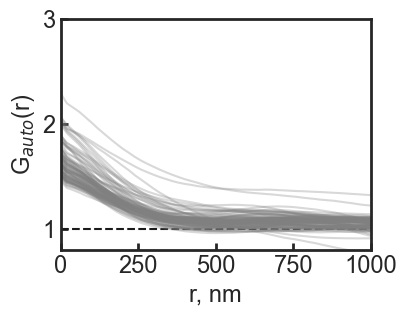

In [8]:
# Plot individual curves for perLoc
lst_PCF_per_condensate = dict4["lst_auto_PCF"]

plt.figure(figsize=(4, 3))
plt.axhline(1, c="k", ls="--")
for current_PCF in lst_PCF_per_condensate:
    plt.plot(bins, current_PCF, c="gray", alpha=0.3)
plt.xlim(bins[0], bins[-1])
plt.ylim(0.8, 3)
plt.xlabel("r, nm", fontsize=17)
plt.ylabel(r"G$_{auto}$(r)", fontsize=17)
plt.gca().spines[:].set_linewidth(2)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=17,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)

### autoPCF weighted mean + STD

#### pre processing

In [9]:
def remove_nan(lst_N_locations, lst_PCF_per_condensate):
    lst_N_locations_clean = []
    lst_PCF_per_condensate_clean = []
    for Nloc, pcf in zip(lst_N_locations, lst_PCF_per_condensate):
        if np.isnan(Nloc):
            continue
        elif np.isnan(pcf).any():
            continue
        else:
            lst_N_locations_clean.append(Nloc)
            lst_PCF_per_condensate_clean.append(pcf)

    return lst_N_locations_clean, lst_PCF_per_condensate_clean


def preprocessing(dict_input, bounds):
    lst_N_locations, lst_PCF_per_condensate = remove_nan(
        dict_input["lst_N_locations"], dict_input["lst_auto_PCF"]
    )

    weighted_mean, weighted_sem, weighted_std = weighted_stats(
        lst_PCF_per_condensate, lst_N_locations
    )
    popt, pcov = curve_fit(
        critical_system_PCF, bins[1:], weighted_mean[1:], bounds=bounds
    )
    a, r0 = popt

    # Bootstrapping
    lst_A, lst_r0, lst_red_chi2 = bootstrap(
        bins,
        lst_PCF_per_condensate,
        lst_N_locations,
        bounds,
        30,
        1000,
    )
    ci_A = (np.percentile(lst_A, 5), np.percentile(lst_A, 95))
    bs_A_mean = np.mean(ci_A)
    bs_A_err = (ci_A[1] - ci_A[0]) / 2
    ci_r0 = (np.percentile(lst_r0, 5), np.percentile(lst_r0, 95))
    bs_r0_mean = np.mean(ci_r0)
    bs_r0_err = (ci_r0[1] - ci_r0[0]) / 2

    return (
        weighted_mean,
        weighted_sem,
        weighted_std,
        a,
        r0,
        lst_A,
        lst_r0,
        bs_A_mean,
        bs_A_err,
        bs_r0_mean,
        bs_r0_err,
    )

In [10]:
bounds = ([-1, 0], [5, 500])

(
    weighted_mean_3,
    weighted_sem_3,
    weighted_std_3,
    a_3,
    r0_3,
    lst_A_3,
    lst_r0_3,
    bs_A_mean_3,
    bs_A_err_3,
    bs_r0_mean_3,
    bs_r0_err_3,
) = preprocessing(dict3, bounds)

(
    weighted_mean_2,
    weighted_sem_2,
    weighted_std_2,
    a_2,
    r0_2,
    lst_A_2,
    lst_r0_2,
    bs_A_mean_2,
    bs_A_err_2,
    bs_r0_mean_2,
    bs_r0_err_2,
) = preprocessing(dict2, bounds)

(
    weighted_mean_4,
    weighted_sem_4,
    weighted_std_4,
    a_4,
    r0_4,
    lst_A_4,
    lst_r0_4,
    bs_A_mean_4,
    bs_A_err_4,
    bs_r0_mean_4,
    bs_r0_err_4,
) = preprocessing(dict4, bounds)

(
    weighted_mean_1,
    weighted_sem_1,
    weighted_std_1,
    a_1,
    r0_1,
    lst_A_1,
    lst_r0_1,
    bs_A_mean_1,
    bs_A_err_1,
    bs_r0_mean_1,
    bs_r0_err_1,
) = preprocessing(dict1, bounds)

#### Plot G_auto

In [11]:
r0_1, r0_2, r0_3, r0_4, a_1, a_2, a_3, a_4

(282.084027043917,
 151.18280425662826,
 170.0059656833769,
 239.65422731061838,
 1.0358024398945866,
 0.4832313104704167,
 0.9764304265223118,
 0.6621862698081649)

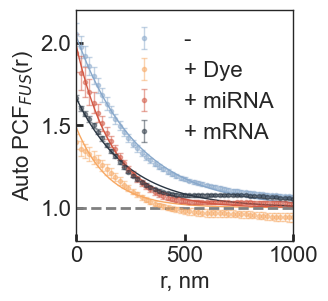

In [15]:
def preset_plot(weighted_mean, weighted_sem, a, r0, c, label):
    plt.errorbar(
        bins,
        weighted_mean,
        yerr=weighted_sem,
        fmt=".",
        color=c,
        ecolor=c,
        elinewidth=1,
        capsize=2,
        alpha=0.5,
        label=label,
    )
    r_fit = np.linspace(bins[0], bins[-1], 500)
    plt.plot(
        r_fit,
        critical_system_PCF(r_fit, a, r0),
        c=c,
        lw=1,
    )


plt.figure(figsize=(2.8, 3))
fontsize = 16
preset_plot(weighted_mean_1, weighted_sem_1, a_1, r0_1, color1, label1)
preset_plot(weighted_mean_2, weighted_sem_2, a_2, r0_2, color2, label2)
preset_plot(weighted_mean_3, weighted_sem_3, a_3, r0_3, color3, label3)
preset_plot(weighted_mean_4, weighted_sem_4, a_4, r0_4, color4, label4)
plt.axhline(1, ls="--", c="gray", lw=2)
# Other plot settings
plt.legend(frameon=False, fontsize=fontsize)
plt.xlim(bins[0], bins[-1])
plt.ylim(0.8, 2.2)
plt.xlabel("r, nm", fontsize=fontsize)
plt.ylabel("Auto PCF$_{FUS}$(r)", fontsize=fontsize)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=fontsize,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)

plt.savefig(
    "weighted_mean_SEM-" + postfix,
    format="png",
    bbox_inches="tight",
    dpi=600,
)

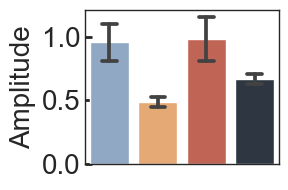

In [17]:
# Create the DataFrame
df_hist = pd.DataFrame(
    {
        "value": np.concatenate(
            [
                np.array(lst_A_1),
                np.array(lst_A_2),
                np.array(lst_A_3),
                np.array(lst_A_4),
            ]
        ),
        "label": np.concatenate(
            [
                np.repeat(label1, len(lst_A_1)),
                np.repeat(label2, len(lst_A_2)),
                np.repeat(label3, len(lst_A_3)),
                np.repeat(label4, len(lst_A_4)),
            ]
        ),
    },
    dtype=object,
)

# Aggregate data for bar plot
# For example, calculating mean values for each label
df_bar = df_hist.groupby("label")["value"].mean().reset_index()

# Plotting the bar plot
plt.figure(figsize=(2.5, 2))
fontsize = 20
ax = sns.barplot(
    data=df_hist,
    x="label",
    y="value",
    order=[label1, label2, label3, label4],
    palette=palette,
    errorbar="sd",
    capsize=0.3,
)

plt.xlabel("")
plt.xticks([])
plt.ylabel("Amplitude", fontsize=fontsize)
plt.yticks([0, 0.5, 1])
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=fontsize,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)
plt.savefig(
    "bar_plot_compare_A-" + postfix,
    format="png",
    bbox_inches="tight",
    dpi=600,
)

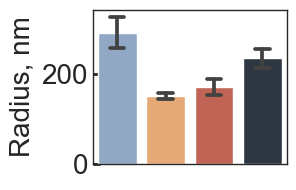

In [19]:
# Create the DataFrame
df_hist = pd.DataFrame(
    {
        "value": lst_r0_1 + lst_r0_2 + lst_r0_3 + lst_r0_4,
        "label": np.concatenate(
            [
                np.repeat(label1, len(lst_r0_1)),
                np.repeat(label2, len(lst_r0_2)),
                np.repeat(label3, len(lst_r0_3)),
                np.repeat(label4, len(lst_r0_4)),
            ]
        ),
    },
    dtype=object,
)

# Aggregate data for bar plot
# For example, calculating mean values for each label
df_bar = df_hist.groupby("label")["value"].mean().reset_index()

# Plotting the bar plot
plt.figure(figsize=(2.5, 2))
fontsize = 20
ax = sns.barplot(
    data=df_hist,
    x="label",
    y="value",
    order=[label1, label2, label3, label4],
    palette=palette,
    errorbar="sd",
    capsize=0.3,
)

plt.xlabel("")
plt.xticks([])
plt.ylabel("Radius, nm", fontsize=fontsize)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=fontsize,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)
plt.savefig(
    "bar_plot_compare_r0-" + postfix,
    format="png",
    bbox_inches="tight",
    dpi=600,
)

### Bootstrap histogram comparison

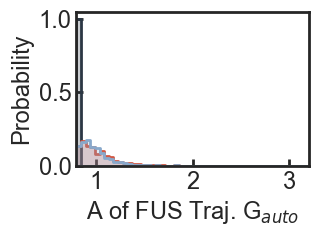

In [40]:
A_range = (0.8, 3.2)
df_hist = pd.DataFrame(
    {
        "value": np.concatenate(
            [
                np.array(lst_A_1),
                np.array(lst_A_2),
                np.array(lst_A_3),
                np.array(lst_A_4),
            ]
        ),
        "label": np.concatenate(
            [
                np.repeat(label1, len(lst_A_1)),
                np.repeat(label2, len(lst_A_2)),
                np.repeat(label3, len(lst_A_3)),
                np.repeat(label4, len(lst_A_4)),
            ]
        ),
    },
    dtype=object,
)
plt.figure(figsize=(3, 2))
ax = sns.histplot(
    data=df_hist,
    x="value",
    hue="label",
    hue_order=[label1, label2, label3, label4],
    palette=palette,
    bins=50,
    binrange=A_range,
    stat="probability",
    common_norm=False,
    lw=2,
    element="step",
    legend=False,
)
plt.xlim(A_range[0], A_range[1])
plt.xlabel("A of FUS Traj. G$_{auto}$", fontsize=17)
plt.ylabel("Probability", fontsize=17)
plt.gca().spines[:].set_linewidth(2)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=17,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)
plt.savefig(
    "bootstrap_histo_compare_A-" + postfix,
    format="png",
    bbox_inches="tight",
    dpi=300,
)

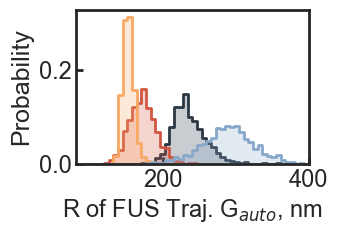

In [41]:
R_range = (80, 400)
df_hist = pd.DataFrame(
    {
        "value": lst_r0_1 + lst_r0_2 + lst_r0_3 + lst_r0_4,
        "label": np.concatenate(
            [
                np.repeat(label1, len(lst_r0_1)),
                np.repeat(label2, len(lst_r0_2)),
                np.repeat(label3, len(lst_r0_3)),
                np.repeat(label4, len(lst_r0_4)),
            ]
        ),
    },
    dtype=object,
)
plt.figure(figsize=(3, 2))
ax = sns.histplot(
    data=df_hist,
    x="value",
    hue="label",
    hue_order=[label1, label2, label3, label4],
    palette=palette,
    bins=50,
    binrange=R_range,
    stat="probability",
    common_norm=False,
    lw=2,
    element="step",
    legend=False,
)
plt.xlim(R_range[0], R_range[1])
plt.xlabel("R of FUS Traj. G$_{auto}$, nm", fontsize=17)
plt.ylabel("Probability", fontsize=18)
plt.gca().spines[:].set_linewidth(2)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=17,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)
plt.savefig(
    "bootstrap_histo_compare_r0-" + postfix,
    format="png",
    bbox_inches="tight",
    dpi=300,
)